# Imports

In [1]:
import numpy as np
import tensorflow as tf
from common.model import create_ssm, get_ssm_weights, set_ssm_weights
from common.data import generate_inputs, create_one_hot_array
from common.train import train

np.set_printoptions(linewidth=200)
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0:1], 'GPU')

2024-10-19 16:52:39.917249: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-19 16:52:45.437078: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-19 16:52:45.439011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-10-19 16:52:45.496109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-10-19 16:52:45.496791: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:3e:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573

# Global variables

In [2]:
sd_baseline = 1
sd_special = 1
epochs = int(1e6)
log_period = 100
print_period = int(1e4)
n_evals = 7
epochs_after_opt = 1500

# Length = 6, teacher state dim = 2, student state dim = 10

## Shared setup

In [3]:
seed = 302
teacher_state_dim = 2
student_state_dim = 10
sd_A = 0.01
sd_B_C = 0.01
length = 6
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(2 * np.log10(1 / sd_A))

In [4]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
B[0, 0] = 1
B[0, 1] = 1
C[0, 0] = 1
C[1, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

2024-10-19 16:52:45.556525: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-19 16:52:45.558527: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-10-19 16:52:45.559351: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3d:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-10-19 16:52:45.559394: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-10-19 16:52:45.559427: I tensorflow/stream_executor/

## 8 baseline inputs, 0 special inputs

In [5]:
base_lr = 0.01
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
title = 'SSM,\nwithout special sequences'

In [6]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

2024-10-19 16:52:46.650647: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


2024-10-19 16:52:47.155260: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-10-19 16:52:47.176038: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 2.1546099185943604
7 absolute largest EVs of A: [0.02140439 0.02048876 0.01325951 0.01279907 0.00455702 0.00347678 0.0032957 ]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009955767542123795
7 absolute largest EVs of A: [1.0457963  0.5464293  0.01731453 0.01632091 0.00467143 0.00352599 0.00333825]
+-------------+
|Final results|
+-------------+
Train loss: 1.8119506421498954e-05
7 absolute largest EVs of A: [0.98926246 0.7997629  0.01732822 0.0163324  0.00467169 0.0035261  0.00333835]
------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------

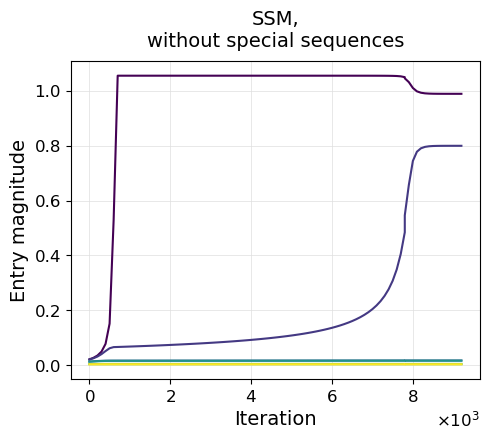

In [7]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

## 8 baseline inputs, 10 special inputs

In [8]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:2, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [9]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 3.4367923736572266
7 absolute largest EVs of A: [0.02140497 0.02049127 0.01326311 0.0128022  0.00455841 0.0034793  0.00329693]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009907606989145279
7 absolute largest EVs of A: [1.0478046  0.41336948 0.10835344 0.10247431 0.03554053 0.02972661 0.02878446]
+-------------+
|Final results|
+-------------+
Train loss: 0.006318770814687014
7 absolute largest EVs of A: [1.0504035  0.47381207 0.09593296 0.08983321 0.02180349 0.01597555 0.01503181]
------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------

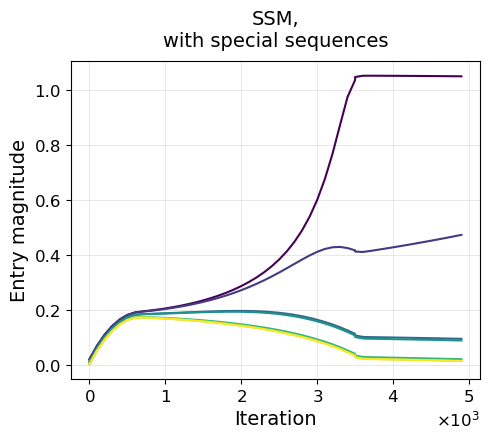

In [10]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

# Length = 10, teacher state dim = 1, student state dim = 20

## Shared setup

In [11]:
seed = 1202
teacher_state_dim = 2
student_state_dim = 20
sd_A = 0.01
sd_B_C = 0.001
length = 10
ext_length = 40
n_baseline = 8
n_special = 10
eps = 0.01
diff = 0.05 / np.exp(3 * np.log10(1 / sd_A))

In [12]:
teacher, _ = create_ssm(teacher_state_dim, length, seed, 1, 1, 0)
A = np.zeros((teacher_state_dim, teacher_state_dim))
B = np.zeros((1, teacher_state_dim))
C = np.zeros((teacher_state_dim, 1))
A[0, 0] = 0.99
A[1, 1] = 0.8
B[0, 0] = 1
B[0, 1] = 1
C[0, 0] = 1
C[1, 0] = 1
set_ssm_weights(teacher, [A, B, C])
ext_teacher, _ = create_ssm(teacher_state_dim, ext_length, seed, 1, 1, 0)
set_ssm_weights(ext_teacher, get_ssm_weights(teacher))

## 8 baseline inputs, 0 special inputs

In [13]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
title = 'SSM,\nwithout special sequences'

In [14]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 12.511759757995605
7 absolute largest EVs of A: [0.02232405 0.02220013 0.01623535 0.01574373 0.01383059 0.01363042 0.01098979]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009867729619145393
7 absolute largest EVs of A: [1.0040843  0.74444103 0.0518836  0.04711918 0.0332303  0.03208972 0.02045867]
+-------------+
|Final results|
+-------------+
Train loss: 1.577862008161901e-06
7 absolute largest EVs of A: [0.990082   0.79994935 0.05198102 0.0471994  0.03326843 0.03212526 0.02047248]
------------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------

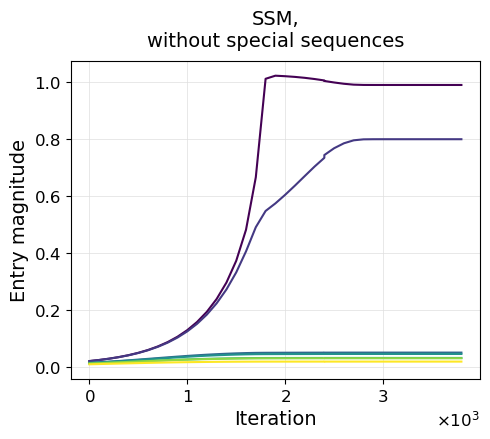

In [15]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)

## 8 baseline inputs, 10 special inputs

In [16]:
base_lr = 0.001
baseline_input = np.zeros((n_baseline, length, 1))
baseline_input[:, 0:length-3, :] = 1
special_input = np.zeros((n_special, length, 1))
special_input[:, length-2:length-1, :] = 1
title = 'SSM,\nwith special sequences'

In [17]:
train_inputs = generate_inputs(1, sd_baseline, sd_special, seed=seed, baseline_input=baseline_input, 
                               special_input=special_input)
train_outputs = teacher(train_inputs)
ext_inputs = create_one_hot_array(ext_length, 1)
ext_outputs = ext_teacher(ext_inputs)

-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 6.875060081481934
7 absolute largest EVs of A: [0.02232413 0.02220029 0.01623562 0.01574374 0.0138307  0.01363057 0.01098984]
+------------------------------+
|Reached sub-epsilon train loss|
+------------------------------+
-------------------------------------------------------
-------------------------------------------------------
Epoch: 0
Train loss: 0.009883532300591469
7 absolute largest EVs of A: [ 1.0053712   0.73522776  0.11798693  0.10652795  0.07015314  0.0669392  -0.0417687 ]
+-------------+
|Final results|
+-------------+
Train loss: 8.855956821207656e-07
7 absolute largest EVs of A: [ 0.99012536  0.799487    0.11066574  0.09909662  0.0624717   0.05924189 -0.04954529]
------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------

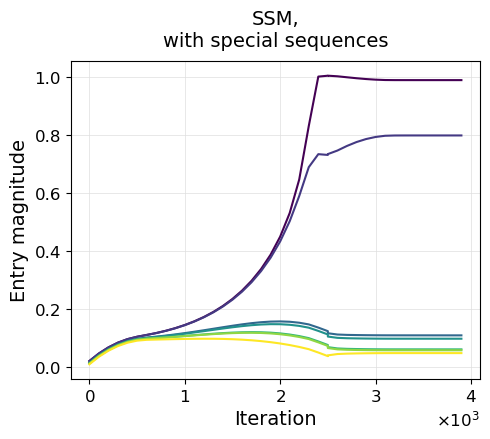

In [18]:
train(train_inputs, train_outputs, ext_inputs, ext_outputs, student_state_dim, seed, sd_A, sd_B_C, base_lr, epochs, 
      eps, diff, adaptive=True, log_period=log_period, print_period=print_period, n_evals=n_evals, 
      epochs_after_opt=epochs_after_opt, exper_type='dynamics', fix_B_C=True, title=title)